In [56]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

import yaml

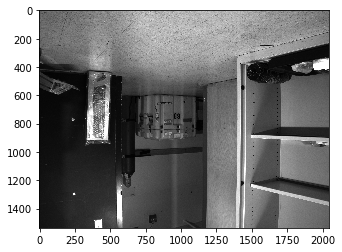

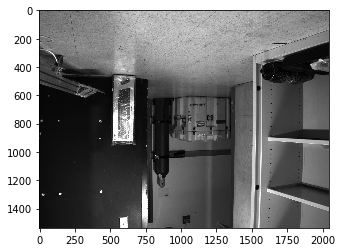

In [16]:

left_image_file = "images/right_raw.png"
left_camera_file = "camera_info/left_rightside_up.yaml"
#left_camera_file = "camera_info/18296567.yaml"

right_image_file = "images/left_raw.png"
right_camera_file = "camera_info/right_rightside_up.yaml"
#right_camera_file = "camera_info/18457940.yaml"



imgL = cv2.imread(left_image_file)
imgR = cv2.imread(right_image_file)

imgLmono = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)
imgRmono = imgR[:,:,1]

plt.imshow(imgLmono, cmap="gray")
plt.show()

plt.imshow(imgRmono, cmap="gray")
plt.show()

In [17]:
import pprint as pp

def mat_from_dict( d ):
    return np.reshape( d['data'], (d['rows'], d['cols'] ) )

def cam_from_yaml( y ):
    return { 'size': (y['image_width'], y['image_height']),
             'K': mat_from_dict( y['camera_matrix'] ),
             'dist': mat_from_dict( y['distortion_coefficients']),
             'projection': mat_from_dict( y['projection_matrix']),
             'rectification': mat_from_dict( y['rectification_matrix'])}

with open(left_camera_file) as f:
    y = yaml.load(f, Loader=yaml.SafeLoader)
    leftCam = cam_from_yaml( y )
    
with open(right_camera_file) as f:
    y = yaml.load(f, Loader=yaml.SafeLoader)
    rightCam = cam_from_yaml(y)
    
pp.pprint(leftCam)
    
    

{'K': array([[1.83056587e+03, 0.00000000e+00, 1.04474165e+03],
       [0.00000000e+00, 1.83197836e+03, 7.85183684e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[-0.176157,  0.092238, -0.000311,  0.00055 ,  0.      ]]),
 'projection': array([[2.15453328e+03, 0.00000000e+00, 1.06673495e+03, 0.00000000e+00],
       [0.00000000e+00, 2.15453328e+03, 7.94799606e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 'rectification': array([[ 9.96963e-01,  6.86300e-03,  7.75680e-02],
       [-6.77200e-03,  9.99976e-01, -1.43400e-03],
       [-7.75760e-02,  9.04000e-04,  9.96986e-01]]),
 'size': (2048, 1536)}


## Just Undistort

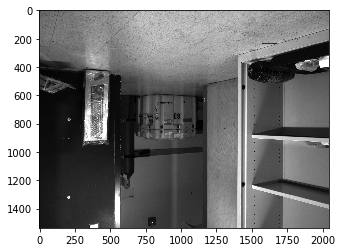

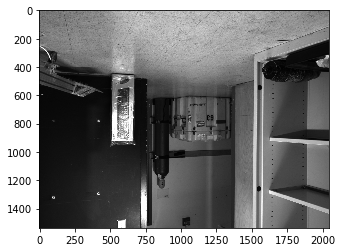

In [18]:
imgLundistort = cv2.undistort( imgLmono,  leftCam['K'],  leftCam['dist'])
imgRundistort = cv2.undistort( imgRmono, rightCam['K'], rightCam['dist'])

plt.imshow(imgLundistort, cmap="gray")
plt.show()
plt.imshow(imgRundistort, cmap="gray")
plt.show()

## Rectify

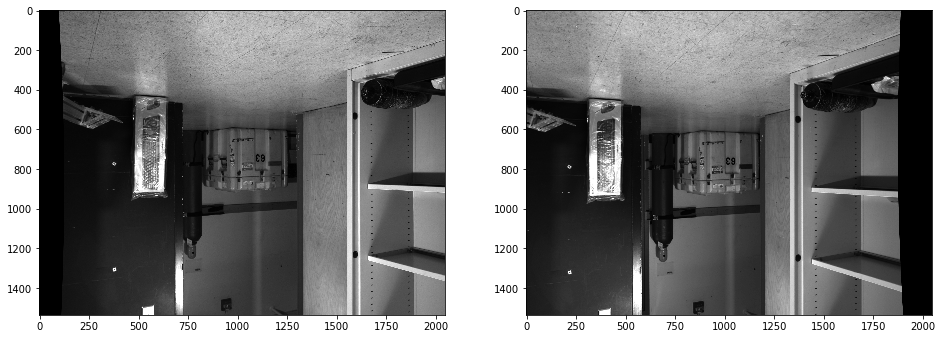

In [19]:
def remap( img, cam ):
    map1,map2 = cv2.initUndistortRectifyMap( cam['K'], cam['dist'], cam['rectification'], cam['K'], cam['size'], cv2.CV_32FC1)
    return cv2.remap(img, map1, map2, cv2.INTER_LINEAR);

imgLrect = remap( imgLmono, leftCam )
imgRrect = remap( imgRmono, rightCam )


fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].imshow(imgLrect, cmap="gray")
axs[1].imshow(imgRrect, cmap="gray")
plt.show()

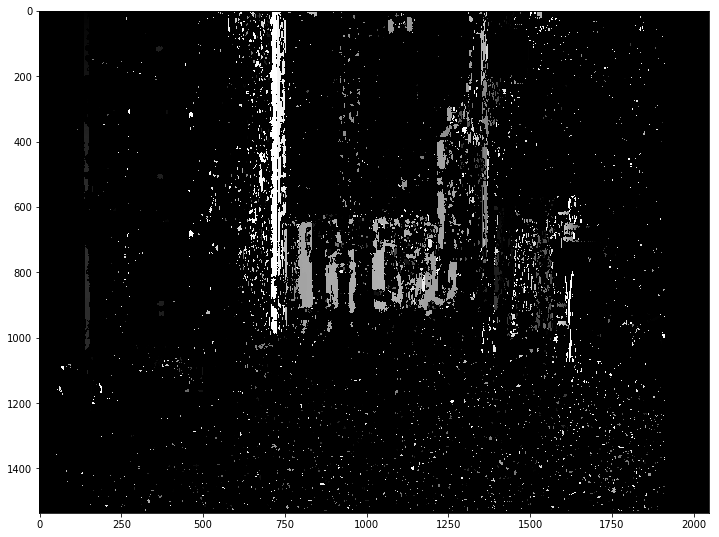

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)

In [63]:
def do_stereo( stereo ):
    disparity = stereo.compute(imgLrect,imgRrect)

    plt.figure(figsize=(12,12))
    plt.imshow(np.rot90(disparity,k=2),'gray', )
    plt.show()
    
    return disparity

   
bm = cv2.StereoBM_create(numDisparities=128, blockSize=15)
bm.setTextureThreshold(4)
bm.setMinDisparity(0)


do_stereo(bm)


## SGBN

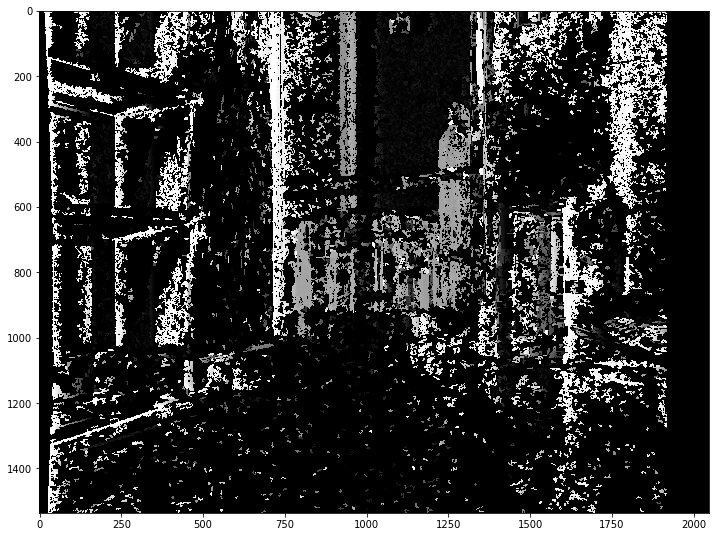

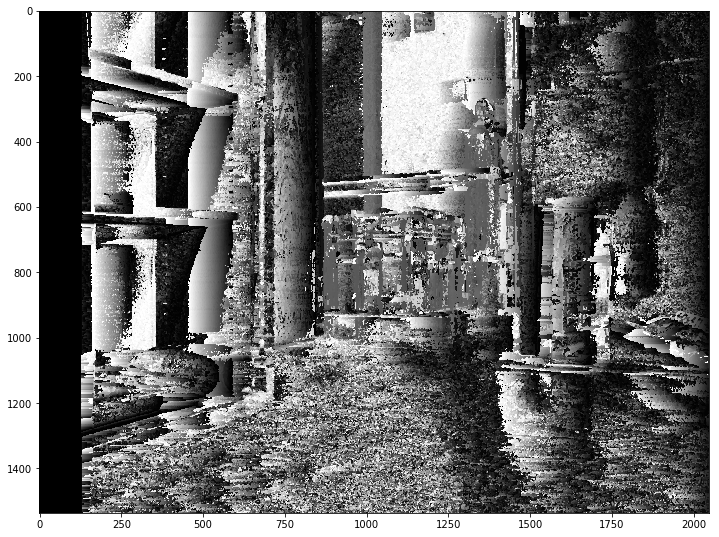

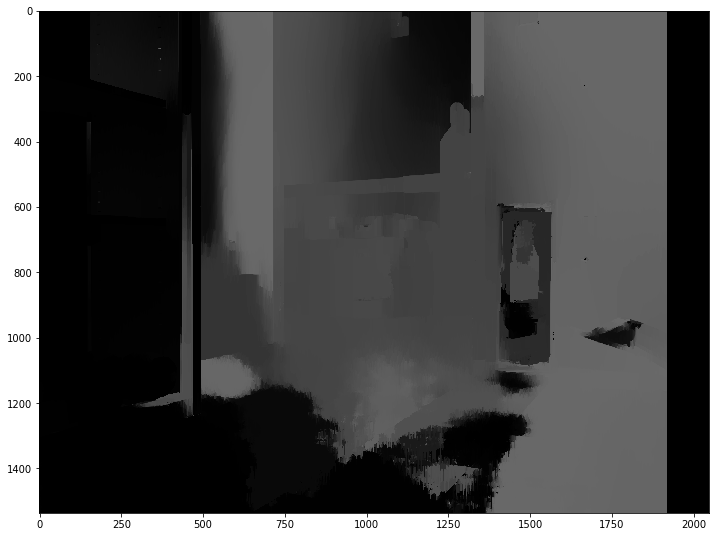

In [66]:

max_disparity = 128;
sgbm = cv2.StereoSGBM_create(minDisparity=0, 
                             numDisparities=max_disparity, 
                             blockSize=5,
                             disp12MaxDiff=10,
                             P1 = 1,
                             P2 = 4,
                             uniquenessRatio=2,
                             speckleWindowSize=50,
                             speckleRange=2);

dispL = do_stereo(sgbm)

right_matcher = cv2.ximgproc.createRightMatcher(sgbm)
dispR = right_matcher.compute(imgRrect, imgLrect)  # .astype(np.float32)/16
# dispL = np.int16(dispL)
# dispR = np.int16(dispR)

## Display right-to-left disparity
plt.figure(figsize=(12,12))
plt.imshow(np.rot90(dispR,k=2),'gray')
plt.show()

# FILTER Parameters
lmbda = 80000
sigma = 1.2
visual_multiplier = 1.0
 
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=sgbm)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

filteredImg = wls_filter.filter(dispL, imgLrect, None, dispR)

filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
filteredImg = np.uint8(filteredImg)

plt.figure(figsize=(12,12))
plt.imshow(np.rot90(filteredImg,k=2),'gray')
plt.show()
